### 셀0. 공통 유틸리티 함수 정의

In [1]:
import pandas as pd
import numpy as np

def get_numeric_cols(cols, df):
    """수치형 컬럼 리스트 반환"""
    return [col for col in cols if pd.api.types.is_numeric_dtype(df[col])]

def get_categorical_cols(cols, df):
    """범주형 컬럼 리스트 반환"""
    return [col for col in cols if pd.api.types.is_object_dtype(df[col]) or isinstance(df[col].dtype, pd.CategoricalDtype)]

def get_datetime_cols(cols, df):
    """날짜형 컬럼 리스트 반환"""
    return [col for col in cols if pd.api.types.is_datetime64_any_dtype(df[col])]

def remove_outliers_iqr(df, cols, iqr_factor=2.5):
    """IQR 방식 이상치 제거 후 DataFrame 반환"""
    df_out = df.copy()
    for col in cols:
        if pd.api.types.is_numeric_dtype(df_out[col]):
            Q1, Q3 = df_out[col].quantile([0.25, 0.75])
            IQR = Q3 - Q1
            lower, upper = Q1 - iqr_factor * IQR, Q3 + iqr_factor * IQR
            df_out = df_out[(df_out[col] >= lower) & (df_out[col] <= upper)]
    return df_out

def find_constant_cols(df, cols):
    """분산 0 또는 유니크값 1개인 컬럼 리스트 반환"""
    const_cols = []
    for col in cols:
        col_data = df[col].dropna()
        if col_data.nunique() <= 1 or (pd.api.types.is_numeric_dtype(col_data) and col_data.var() == 0):
            const_cols.append(col)
    return const_cols

### 셀1. 데이터 로드 및 1차 EDA

In [2]:
import pandas as pd
from IPython.display import display_html

# 변수 리스트 및 파일 경로 설정
file_path = 'rawdata/Fab1_Fab2 CoA+All Data Merge_0915_Crystal 기술팀 송부_의성 1(Fab1_Fab2 CoA+All Data Merge_09).csv'

y_columns = ['YIELD']

             # 날짜 변수 
x_columns = ['SHIP DATE', 'tkout_date', 'PULLING DATE', 'I_FINAL CLEAN DATE',
             # Crystal 변수 
             'PULLER NO', 'Recharge Sequence', 'Ingot Position', 'M_RES-CAL', 'M_CRYSTAL ORIENTATION', 'M_CRYSTAL ORIENTATION X-AXIS', 'M_CRYSTAL ORIENTATION Y-AXIS', 'M_EDGE RES-TOP', 'M_EDGE RES-BOTTOM',
             'M_EDGE OXYGEN-TOP', 'M_EDGE OXYGEN-BOTTOM', 'Defect Type ', 'Pi Width', 'SLOT',]
             # Wafering 변수 
            #  'SLOT', 'F_RESISTIVITY-TOP', 'F_RESISTIVITY-BOTTOM', 'F_OXYGEN-TOP', 'F_OXYGEN-BOTTOM', 'F_ROG-TOP', 'F_ROG-BOTTOM', 'F_RRG-TOP', 'F_RRG-BOTTOM', 'M_CARBON-TOP', 'M_CARBON-BOTTOM',
            #  'R_POLY_ARSENIC', 'R_POLY_BORON', 'R_POLY_CARBON', 'R_POLY_PHOSPHOROUS', 'M_DCO-0.037', 'M_DCO-0.047', 'M_DCO-0.050', 'M_DCO-0.065', 'M_DCO-0.08', 'M_DCO-0.10', 'M_DCO-0.12', 'M_DCO-0.16',
            #  'M_DCO-0.20', 'M_LPDN-0.10', 'M_AREA COUNT', 'DOMING2', 'WFACTOR2', 'F_THICKNESS', 'F_GBIR', 'F_GFLR', 'F_SFQR', 'F_ESFQR', 'F_BOW', 'F_WARP', 'M_H1', 'ESFQR2M', 'ERO147', 'ERO148', 'ERO149',
            #  'ZDD_147', 'ZDD_148', 'ZDD_149', 'M_THK#AVG', 'M_THK#MAX', 'M_THK#MIN', 'M_THK#N', 'M_THK#STD', 'M_SFQR#AVG', 'M_SFQR#MIN', 'M_SFQR#N', 'M_SFQR#STD', 'M_ESFQR#AVG', 'M_ESFQR#MIN', 'M_ESFQR#N',
            #  'M_ESFQR#STD', 'F_SURFACE METAL-AL', 'F_SURFACE METAL-CA', 'F_SURFACE METAL-CR', 'F_SURFACE METAL-CU', 'F_SURFACE METAL-FE', 'F_SURFACE METAL-NA', 'F_SURFACE METAL-NI', 'F_SURFACE METAL-ZN',
            #  'F_SURFACE METAL-K', 'F_SURFACE METAL-MG', 'F_SURFACE METAL-MN', 'F_SURFACE METAL-TI', 'F_SURFACE METAL-CO', 'F_SURFACE METAL-W', 'F_SURFACE METAL-MO', 'F_TOTAL METAL', 'M_NOTCH ORIENTATION',
            #  'M_NOTCH DEPTH', 'M_EDGE A1', 'M_EDGE ANG1', 'M_SLICE', 'M_LAPPING_DDSG', 'M_ETCHER', 'M_DSP', 'M_ENP', 'M_FCMP', 'M_FCLN']

               # 필터링 변수 
use_columns = ['PO', 'Wafering Site', 'process_id'] + x_columns + y_columns

# 도메인 필터링 조건
domain_filter = {'PO': ['SAC-QX-56B'], 'Wafering Site': ['Fab1'], 'process_id': ['PRD1']}

def print_domain_filter(filters):
    """도메인 필터링 조건 출력 함수"""
    print('[도메인 필터링 조건]')
    for col, val in filters.items():
        val_str = ', '.join(map(str, val)) if isinstance(val, list) else str(val)
        print(f"- {col} == {val_str}")

def display_3tables_side_by_side(df):
    """데이터프레임을 4분할하여 병렬 HTML 테이블 출력 함수"""
    n = len(df)
    chunk = (n + 2) // 4
    dfs = [df.iloc[i*chunk:(i+1)*chunk].reset_index(drop=True) for i in range(4)]
    html_tables = [d.to_html(index=False) for d in dfs]
    display_html(
        '<div style="display:flex; gap:40px;">' +
        ''.join(f'<div>{t}</div>' for t in html_tables) +
        '</div>', raw=True)

# 실행 파이프라인
print_domain_filter(domain_filter)
df = pd.read_csv(file_path, usecols=use_columns, encoding='cp949')
print(f'도메인 필터링 전 row 수: {len(df):,}')
for key, values in domain_filter.items():
    df = df[df[key].isin(values)].copy()
    print(f'도메인 필터링 후 row 수 ({key}): {len(df):,}')

# 바탕 레이블 생성 (Classification 전용)
# df['INDEX_Class'] = df['INDEX'].map({'100이하': 0, '100이상': 1})
# print(f"\n{df['INDEX_Class'].value_counts(dropna=False)}")

# 날짜형 변환 ('YYYYMMDD' → datetime)
for dt_col, fmt in zip(['SHIP DATE', 'tkout_date', 'PULLING DATE', 'I_FINAL CLEAN DATE'], [None, None, '%Y%m%d', '%Y%m%d']):
    if dt_col in df.columns:
        df[dt_col] = pd.to_datetime(df[dt_col], format=fmt, errors='coerce')

# 의미 없는 컬럼 제거 (유니크 1개 또는 분산 0)
cols_unique = [col for col in df.columns if df[col].nunique(dropna=False) == 1]
cols_var0 = find_constant_cols(df, get_numeric_cols(df.columns, df))
remove_cols = list(set(cols_unique + cols_var0))
df.drop(columns=remove_cols, inplace=True)
print('\n제거된 의미 없는 칼럼:', remove_cols)

# 결측치 30% 이상 컬럼 제거
missing_ratio = df.isnull().mean()
cols_missing = missing_ratio[missing_ratio > 0.3].index.tolist()
df.drop(columns=cols_missing, inplace=True)
print('결측치 30% 이상 칼럼:', cols_missing)

# 결측치 포함 행 제거 후 결과 출력
removed_rows_per_col = {col: df[col].isnull().sum() for col in df.columns if df[col].isnull().sum() > 0}
row_before = len(df)
df.dropna(inplace=True)
row_after = len(df)
print(f"\n[결측치 제거 결과] row: {row_before:,} -> {row_after:,} (-{row_before - row_after:,} rows removed)")
for col, cnt in removed_rows_per_col.items():
    print(f"- {col}: {cnt}개")

# 컬럼 순서 재정렬 (Y 컬럼 + X 컬럼)
ordered_cols = [col for col in y_columns if col in df.columns] + [col for col in x_columns if col in df.columns]
df = df[ordered_cols]

# 컬럼 데이터 타입 및 유니크 개수 요약 출력
col_info = pd.DataFrame({
    'Column': df.columns,
    'DataType': df.dtypes.astype(str),
    'Unique Count': df.nunique(dropna=False)
})

print('\n[컬럼별 데이터 타입 및 유니크 개수]')
display_3tables_side_by_side(col_info)

[도메인 필터링 조건]
- PO == SAC-QX-56B
- Wafering Site == Fab1
- process_id == PRD1
도메인 필터링 전 row 수: 44,020
도메인 필터링 후 row 수 (PO): 37,937
도메인 필터링 후 row 수 (Wafering Site): 37,937
도메인 필터링 후 row 수 (process_id): 35,888

제거된 의미 없는 칼럼: ['PO', 'Wafering Site', 'process_id']
결측치 30% 이상 칼럼: []

[결측치 제거 결과] row: 35,888 -> 35,090 (-798 rows removed)
- M_EDGE RES-TOP: 798개
- M_EDGE RES-BOTTOM: 798개
- M_EDGE OXYGEN-TOP: 798개
- M_EDGE OXYGEN-BOTTOM: 798개

[컬럼별 데이터 타입 및 유니크 개수]


Column,DataType,Unique Count
YIELD,float64,305
SHIP DATE,datetime64[ns],10
tkout_date,datetime64[ns],84
PULLING DATE,datetime64[ns],68
I_FINAL CLEAN DATE,datetime64[ns],115
Column,DataType,Unique Count
PULLER NO,object,9
Recharge Sequence,int64,3
Ingot Position,float64,9913
M_RES-CAL,float64,282


### 셀2. 전처리(이상치 제거) 및 EDA

무의미 칼럼(분산0, 유니크값1) 없음.
     컬럼명  이상치 제거 row 수
0  YIELD           753
전처리 전 데이터 shape: (35090, 19)
전처리 후 데이터 shape: (34337, 19)
최종 Y_수치형 변수 개수: 1
최종 X_수치형 변수 개수: 12
최종 X_범주형 변수 개수: 2
최종 X_날짜형 변수 개수: 4


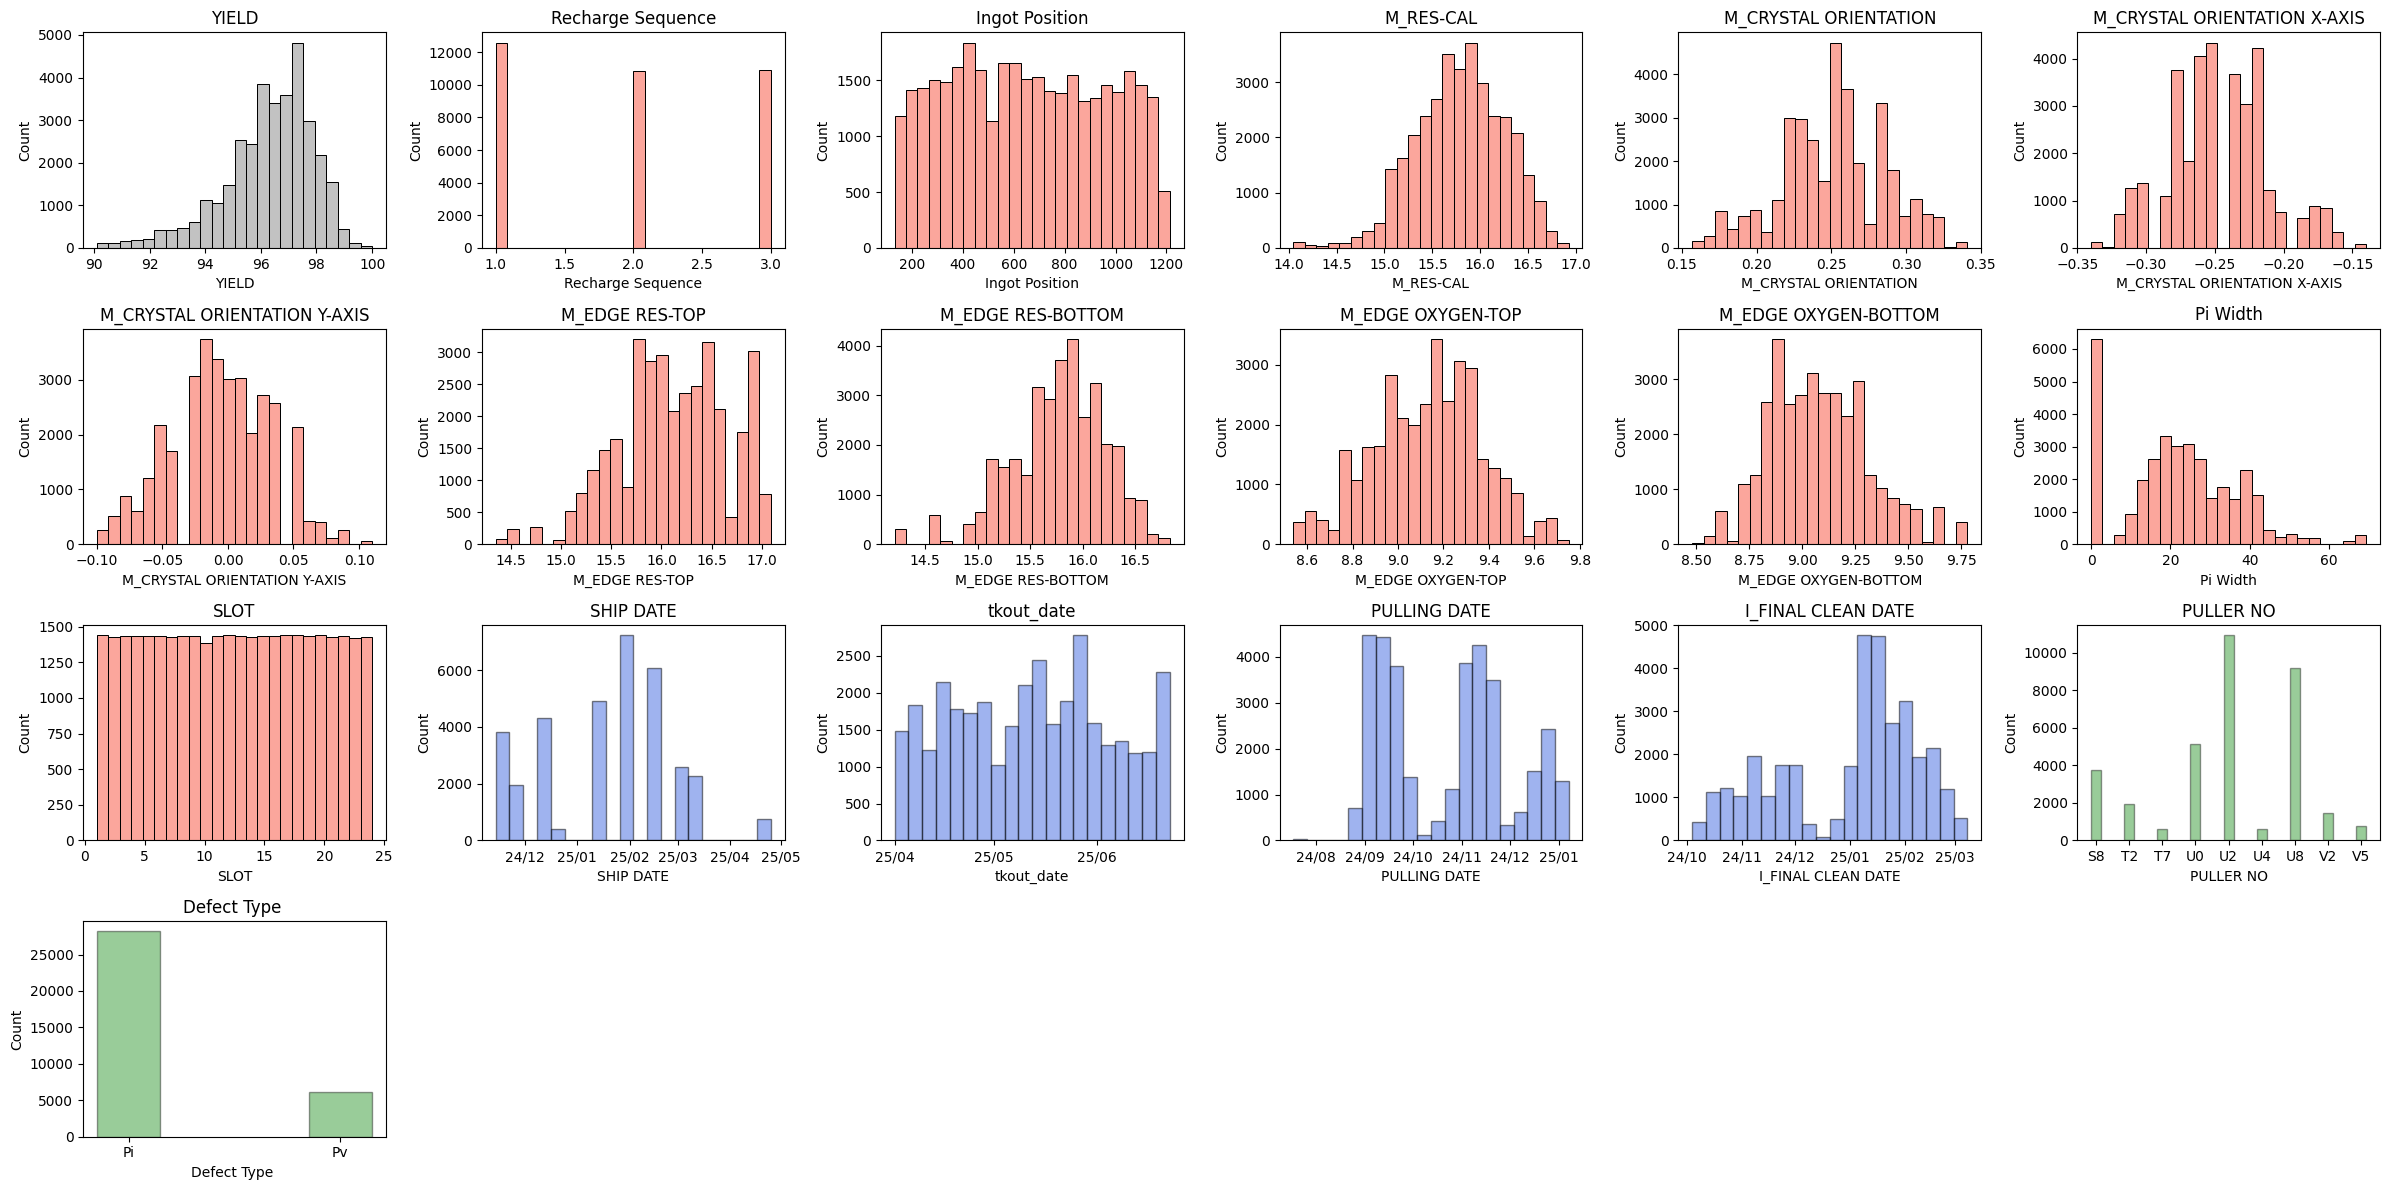

In [3]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import numpy as np

def get_column_types(df, y_columns, x_columns):
    """Y, X 각각 수치형, 범주형, 날짜형 컬럼 구분 함수"""
    y_cols = [col for col in y_columns if col in df.columns]
    x_cols = [col for col in x_columns if col in df.columns]
    y_num = get_numeric_cols(y_cols, df)
    x_num = get_numeric_cols(x_cols, df)
    y_cat = get_categorical_cols(y_cols, df)
    x_cat = get_categorical_cols(x_cols, df)
    y_dt = get_datetime_cols(y_cols, df)
    x_dt = get_datetime_cols(x_cols, df)
    return y_cols, x_cols, y_num, x_num, y_cat, x_cat, y_dt, x_dt

def compact_var_shape(pre, post, var_name):
    """변수 개수 변동 출력 보조 함수"""
    return f"{var_name}: {pre} → {post}" if pre != post else f"{var_name}: {post}"

# ---- [선택] y_columns 이상치 제거 여부 ----
remove_outlier_for_y = True                # True: y_columns 이상치 제거 수행 / False: 제외
# ----------------------------------------

# 컬럼 타입 분리 및 임시 이상치 제거 후 무의미 컬럼 탐색 및 제거
y_cols_pre, x_cols_pre, y_num_pre, x_num_pre, y_cat_pre, x_cat_pre, y_dt_pre, x_dt_pre = get_column_types(df, y_columns, x_columns)
df_iqr_temp = remove_outliers_iqr(df, x_num_pre, iqr_factor=2.5)

constant_cols = find_constant_cols(df_iqr_temp, x_num_pre)
if constant_cols:
    print("무의미 칼럼(분산0, 유니크값1):", constant_cols)
    df_cleaned = df.drop(columns=constant_cols)
else:
    print("무의미 칼럼(분산0, 유니크값1) 없음.")
    df_cleaned = df.copy()

# 무의미 컬럼 제거 후 컬럼 타입 재분리 및 본 이상치 제거
y_cols_post, x_cols_post, y_num_post, x_num_post, y_cat_post, x_cat_post, y_dt_post, x_dt_post = get_column_types(df_cleaned, y_columns, x_columns)

if remove_outlier_for_y:
    cols_to_remove_outliers = x_num_post + y_num_post
else:
    cols_to_remove_outliers = x_num_post

df_no_outlier = remove_outliers_iqr(df_cleaned, cols_to_remove_outliers, iqr_factor=2.5)

# 본 이상치 제거로 감소된 row 수 집계 및 출력
removed_rows = {}
for col in cols_to_remove_outliers:
    if col in df_cleaned.columns and pd.api.types.is_numeric_dtype(df_cleaned[col]):
        Q1, Q3 = df_cleaned[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower, upper = Q1 - 2.5 * IQR, Q3 + 2.5 * IQR
        n_outliers = ((df_cleaned[col] < lower) | (df_cleaned[col] > upper)).sum()
        if n_outliers > 0:
            removed_rows[col] = n_outliers

removed_df = pd.DataFrame(list(removed_rows.items()), columns=['컬럼명', '이상치 제거 row 수']).sort_values(by='이상치 제거 row 수', ascending=False).reset_index(drop=True)
print(removed_df if not removed_df.empty else "이상치가 제거된 컬럼 없음.")

# 데이터 shape 변동 출력
print(f"전처리 전 데이터 shape: {df.shape}")
print(f"전처리 후 데이터 shape: {df_no_outlier.shape}")
print(compact_var_shape(len(y_num_pre), len(y_num_post), "최종 Y_수치형 변수 개수"))
print(compact_var_shape(len(x_num_pre), len(x_num_post), "최종 X_수치형 변수 개수"))
print(compact_var_shape(len(x_cat_pre), len(x_cat_post), "최종 X_범주형 변수 개수"))
print(compact_var_shape(len(x_dt_pre), len(x_dt_post), "최종 X_날짜형 변수 개수"))

# 이상치 제거 후 카테고리, 날짜 컬럼 리스트
cat_cols_for_plot = [col for col in (x_cols_post + y_columns) if col in df_no_outlier.columns]
all_categorical = get_categorical_cols(cat_cols_for_plot, df_no_outlier)
all_datetime = get_datetime_cols(cat_cols_for_plot, df_no_outlier)

# 히스토그램 및 분포 시각화
all_cols = [col for col in y_columns if col in df_no_outlier.columns] + \
           [col for col in (x_num_post + all_datetime + all_categorical) if col in df_no_outlier.columns]

n_plots = len(all_cols)
max_cols = 6
n_cols = min(max_cols, n_plots)
n_rows = math.ceil(n_plots / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
axes = axes.flatten()

for i, col in enumerate(all_cols):
    if col in y_columns:
        sns.histplot(df_no_outlier[col], ax=axes[i], color='darkgray', stat='count', bins=24, alpha=0.7, edgecolor='black')
        axes[i].set_title(f'{col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Count')
        uniqs = sorted(df_no_outlier[col].unique())
        if set(uniqs).issubset({0, 1}):
            axes[i].set_xticks([0, 1])
            axes[i].set_xticklabels(['0', '1'])
    elif col in x_num_post:
        sns.histplot(df_no_outlier[col], ax=axes[i], color='salmon', stat='count', bins=24, alpha=0.7, edgecolor='black')
        axes[i].set_title(f'{col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Count')
    elif col in all_datetime:
        data = df_no_outlier[col].dropna()
        if len(data) > 1:
            axes[i].hist(data, bins=20, color='royalblue', alpha=0.5, edgecolor='black')
        axes[i].set_title(f'{col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Count')
        axes[i].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%y/%m'))
        axes[i].tick_params(axis='x', rotation=0)
    else:
        counts = df_no_outlier[col].value_counts().sort_index()
        axes[i].bar(counts.index.astype(str), counts.values, width=0.3, color='green', alpha=0.4, edgecolor='black')
        axes[i].set_title(f'{col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Count')
        axes[i].tick_params(axis='x', rotation=0)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

### [선택사항] 다중공선성 변수 축소

In [ ]:
import math
import numpy as np
import pandas as pd
from IPython.display import display, HTML

def print_corr_pairs_html(pairs, ncol=4):
    """상관 관계 높은 변수 쌍을 HTML 테이블 형태 출력 함수"""
    n = len(pairs)
    nrow = math.ceil(n / ncol)
    percent = 100 // ncol
    html = '<table style="border-collapse: collapse; width: 100%;">\n<tbody>'
    for i in range(nrow):
        html += '<tr>'
        for j in range(ncol):
            idx = i * ncol + j
            if idx < n:
                f1, f2, val = pairs[idx]
                html += (f'<td style="border:1px solid #aaa; padding:6px; '
                         f'font-family: Consolas, monospace; text-align:left; '
                         f'width:{percent}%; overflow:hidden; white-space:nowrap;">'
                         f'{idx+1:3}. {f1} <-> {f2} : {val:.3f}'
                         '</td>')
            else:
                html += f'<td style="width:{percent}%;"></td>'
        html += '</tr>'
    html += '</tbody></table>'
    display(HTML(html))

# 상관관계 행렬 및 변수 제거
X_corr = df_no_outlier[x_cols_post].copy()
y_corr = df_no_outlier[y_columns[0]]

# 수치형 변수 필터링
numeric_features_corr = [col for col in X_corr.columns if pd.api.types.is_numeric_dtype(X_corr[col])]
X_corr_num = X_corr[numeric_features_corr]

# 상관계수 절대값, 상삼각 행렬
corr_matrix = X_corr_num.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

threshold_print = 0.75
threshold_remove = 0.90

high_corr_set = set()
high_corr_pairs = []
for col in upper_tri.columns:
    for row in upper_tri.index:
        val = upper_tri.at[row, col]
        if pd.notna(val) and val > threshold_print:
            pair = tuple(sorted([row, col]))
            if pair not in high_corr_set:
                high_corr_set.add(pair)
                high_corr_pairs.append((pair[0], pair[1], val))
high_corr_pairs.sort(key=lambda x: x[2], reverse=True)

to_drop_mapped = []
for f1, f2, val in [(f1, f2, v) for (f1, f2, v) in high_corr_pairs if v > threshold_remove]:
    corr1 = abs(np.corrcoef(X_corr_num[f1], y_corr)[0, 1])
    corr2 = abs(np.corrcoef(X_corr_num[f2], y_corr)[0, 1])
    to_drop_mapped.append((f1 if corr1 < corr2 else f2, val))

to_drop_set = set(f for f, _ in to_drop_mapped)
to_drop_ordered = [f for f, _ in to_drop_mapped]

print(f"\n상관관계 {int(threshold_print*100)}% 초과하는 Feature 쌍 및 상관계수 (내림차순):")
print_corr_pairs_html(high_corr_pairs, ncol=4)

print(f"\n제거된 칼럼 (상관계수 {int(threshold_remove*100)}% 초과 쌍 중 타깃과 연관성 낮은 칼럼):")
print(", ".join(to_drop_ordered) if to_drop_ordered else "없음")

print(f"\n다중공선성 제거 전 변수 개수: {len(x_cols_post)}")

x_cols_post = [col for col in x_cols_post if col not in to_drop_set]
df_no_outlier.drop(columns=to_drop_set, inplace=True)

print(f"다중공선성 제거 후 변수 개수: {len(x_cols_post)}")

x_num_post_new = [col for col in x_num_post if col in x_cols_post]

print(f"\n최종 Y_수치형 변수 개수: {len(y_num_post)}")
print(f"최종 X_수치형 변수 개수: {len(x_num_post)} → {len(x_num_post_new)}")
print(f"최종 X_범주형 변수 개수: {len(x_cat_post)}")
print(f"최종 X_날짜형 변수 개수: {len(x_dt_post)}")

### 셀3. 파생변수 생성 + 원핫 인코딩

In [4]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# X, Y 분리
y_cols_final = [col for col in y_columns if col in df_no_outlier.columns]
x_cols_final = [col for col in x_columns if col in df_no_outlier.columns]
X = df_no_outlier[x_cols_final].copy()
y = df_no_outlier[y_cols_final].copy() if y_cols_final else None

def create_date_features(df, date_cols):
    """날짜 차이 및 트렌드 변수 생성 함수 (날짜 트렌드 변수별 최소/최대 날짜 정보 반환)"""
    df_out = df.copy()
    date_diff_cols = []
    trend_cols = []
    trend_min_dates = {}
    trend_max_dates = {}

    extra_date_cols = ['SHIP DATE', 'tkout_date', 'PULLING DATE', 'I_FINAL CLEAN DATE']
    if set(extra_date_cols).issubset(df_out.columns):
        df_out['SHIP-TKOUT DAY'] = (df_out['tkout_date'] - df_out['SHIP DATE']).dt.days
        df_out['FCLN-SHIP DAY'] = (df_out['SHIP DATE'] - df_out['I_FINAL CLEAN DATE']).dt.days
        df_out['PULL-FCLN DAY'] = (df_out['I_FINAL CLEAN DATE'] - df_out['PULLING DATE']).dt.days
        date_diff_cols.extend(['SHIP-TKOUT DAY', 'FCLN-SHIP DAY', 'PULL-FCLN DAY'])

    for col in date_cols:
        if col in df_out.columns and np.issubdtype(df_out[col].dtype, np.datetime64):
            min_date, max_date = df_out[col].min(), df_out[col].max()
            delta_days = (max_date - min_date).days or 1
            trend_col = f"{col}_trend"
            df_out[trend_col] = (df_out[col] - min_date).dt.days / delta_days
            trend_cols.append(trend_col)
            trend_min_dates[trend_col] = min_date
            trend_max_dates[trend_col] = max_date

    return df_out, date_diff_cols, trend_cols, trend_min_dates, trend_max_dates

# 날짜 변수 리스트
date_columns_for_diff = ['SHIP DATE', 'tkout_date', 'PULLING DATE', 'I_FINAL CLEAN DATE']

# 파생변수 생성 및 날짜 트렌드 변수별 최소/최대 날짜 정보도 받음
X, date_diff_features, trend_features, trend_min_dates, trend_max_dates = create_date_features(X, date_columns_for_diff)

# -------- [선택] 파생변수 생성 후 csv로 저장 --------
# df_with_y = pd.concat([X, y], axis=1) if y is not None else X
# df_with_y.to_csv('Refined_Data.csv', encoding='utf-8-sig', index=False)
# print("전처리 데이터 csv로 저장 완료")
# ------------------------------------------------

# 원본 날짜형 변수 제거 및 컬럼 리스트 갱신
datetime_features = get_datetime_cols(X.columns, X)
X.drop(columns=datetime_features, inplace=True)
x_cols_final = [col for col in x_cols_final if col not in datetime_features]

# 수치형, 범주형 변수 분리
numeric_features = get_numeric_cols(X.columns, X)
categorical_features = get_categorical_cols(X.columns, X)

# 날짜 파생/트렌드 변수 제외 후 수치형 변수 리스트
excluded_numeric_features = set(date_diff_features + trend_features)
numeric_features_filtered = [col for col in numeric_features if col not in excluded_numeric_features]

# 변수 리스트 출력
print(f"기존 수치형 X변수 (총 {len(numeric_features_filtered)}개):")
print(" ", numeric_features_filtered)
print(f"날짜 파생 X변수 (총 {len(date_diff_features)}개):")
print(" ", date_diff_features)
print(f"날짜 트렌드 X변수 (총 {len(trend_features)}개):")
print(" ", trend_features)

# 범주형 변수 원핫 인코딩
if categorical_features:
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    encoded = encoder.fit_transform(X[categorical_features])
    encoded_cols = encoder.get_feature_names_out(categorical_features)
    encoded_df = pd.DataFrame(encoded, columns=encoded_cols, index=X.index).astype(int)
    
    print(f"범주형 X변수 (총 {len(categorical_features)}개, 인코딩 된 칼럼 수 총 {len(encoded_cols)}개):")
    for cat in categorical_features:
        this_cols = [c for c in encoded_cols if c.startswith(cat + "_")]
        print(f"  - {cat}: {len(this_cols)}개 -> {', '.join(this_cols) if this_cols else ''}")
    print("")
else:
    encoded_cols, encoded_df = [], None
    print(f"범주형 X변수 (총 {len(categorical_features)}개):")
    print(" ", categorical_features)

# 최종 데이터셋 생성
X_no_scaled = X.copy()
if encoded_df is not None:
    X_processed = pd.concat([X_no_scaled.drop(columns=categorical_features), encoded_df], axis=1)
else:
    X_processed = X_no_scaled

# 최종 데이터 크기 출력
print(f"최종 X 데이터 shape: {X_processed.shape}")
if y is not None:
    print(f"최종 Y 데이터 shape: {y.shape}")

기존 수치형 X변수 (총 12개):
  ['Recharge Sequence', 'Ingot Position', 'M_RES-CAL', 'M_CRYSTAL ORIENTATION', 'M_CRYSTAL ORIENTATION X-AXIS', 'M_CRYSTAL ORIENTATION Y-AXIS', 'M_EDGE RES-TOP', 'M_EDGE RES-BOTTOM', 'M_EDGE OXYGEN-TOP', 'M_EDGE OXYGEN-BOTTOM', 'Pi Width', 'SLOT']
날짜 파생 X변수 (총 3개):
  ['SHIP-TKOUT DAY', 'FCLN-SHIP DAY', 'PULL-FCLN DAY']
날짜 트렌드 X변수 (총 4개):
  ['SHIP DATE_trend', 'tkout_date_trend', 'PULLING DATE_trend', 'I_FINAL CLEAN DATE_trend']
범주형 X변수 (총 2개, 인코딩 된 칼럼 수 총 9개):
  - PULLER NO: 8개 -> PULLER NO_T2, PULLER NO_T7, PULLER NO_U0, PULLER NO_U2, PULLER NO_U4, PULLER NO_U8, PULLER NO_V2, PULLER NO_V5
  - Defect Type : 1개 -> Defect Type _Pv

최종 X 데이터 shape: (34337, 28)
최종 Y 데이터 shape: (34337, 1)


### 셀4. 분류 모델 학습 및 SHAP 평가

=== 그리드 탐색 결과 (최적화 지표: r2) ===
최적 파라미터: num_leaves=40, max_depth=8, min_child_samples=40, r2=0.0556

[최종 모델 Train Set 성능]
RMSE    : 1.4938
MAE     : 1.1566
R2 Score: 0.1551

[최종 모델 Test Set 성능]
RMSE    : 1.5824
MAE     : 1.2161
R2 Score: 0.0556


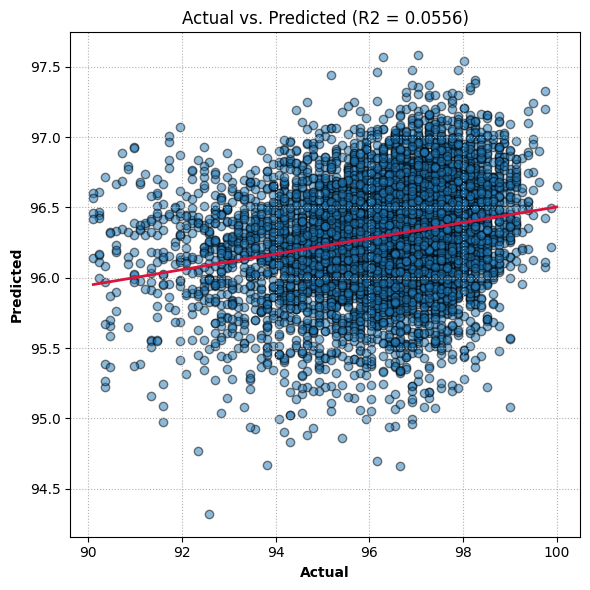

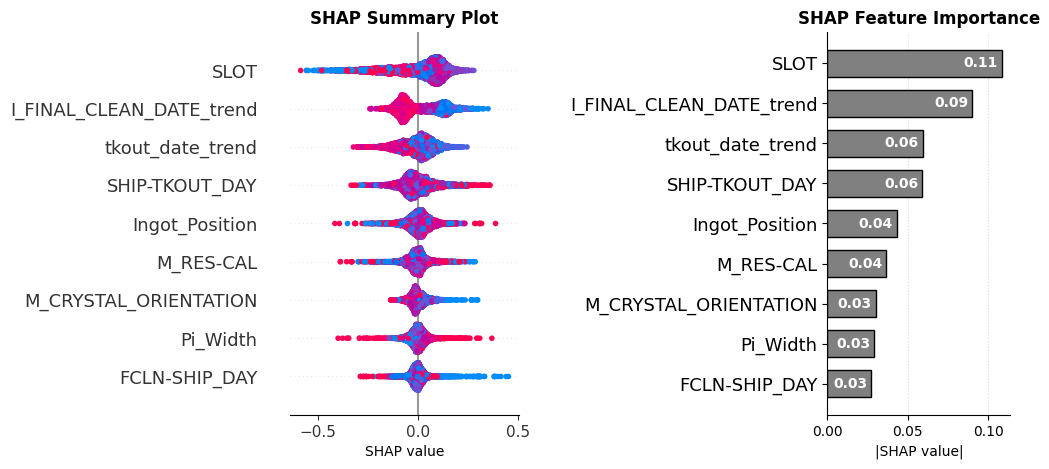

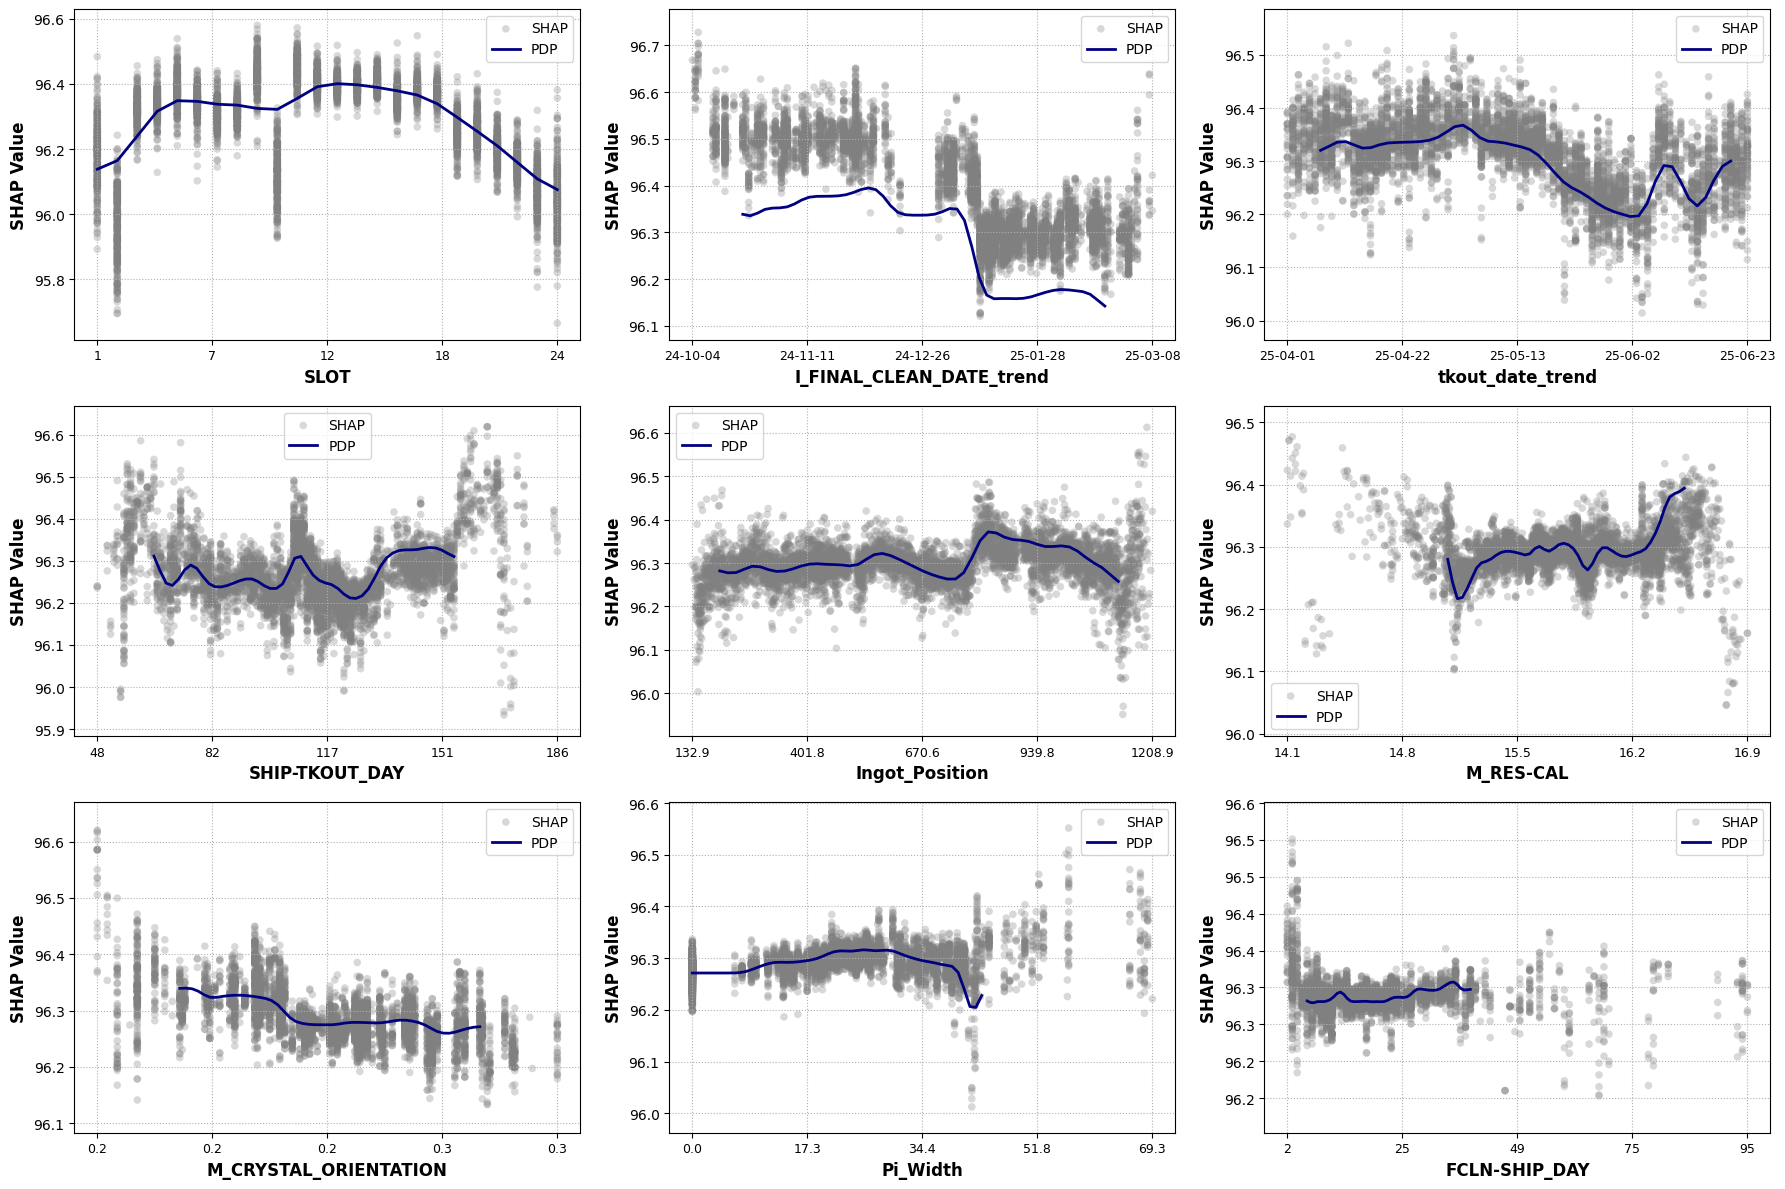

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import shap
import lightgbm as lgb
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, fbeta_score, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, mean_absolute_error, r2_score)
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import gaussian_filter1d
import warnings
from itertools import product
import math
import logging
import sys
import os
import contextlib

# 경고 메시지 무시 및 LightGBM 로그 비활성화
warnings.filterwarnings('ignore')
lgb.basic._log = lambda *args, **kwargs: None

@contextlib.contextmanager
def suppress_stdout_stderr():
    """LightGBM 내부 Info/Warning 메시지 숨기기를 위한 stdout/stderr 리디렉션 함수"""
    with open(os.devnull, "w") as devnull:
        old_stdout, old_stderr = sys.stdout, sys.stderr
        try:
            sys.stdout, sys.stderr = devnull, devnull
            yield
        finally:
            sys.stdout, sys.stderr = old_stdout, old_stderr

# ======== 실행부 사용자 설정 ========
mode = 'regression'                      # classification 또는 regression 직접 지정
use_scaling = True                       # 스케일링 사용 여부 (True/False)
optimization_metric = 'r2'               # 분류: 'accuracy', 'recall', 'f1', 'fbeta' / 회귀: 'rmse', 'mae', 'r2'
beta_value = 2                           # fbeta 지표 사용 시 beta 값 지정 (분류 전용)
# ===================================

def prepare_train_test_data(X, y, test_size=0.2, random_state=42, stratify_col=None, use_scaling=True, mode='classification'):
    """train/test 분할 및 선택적 스케일링 함수"""
    stratify_param = y if stratify_col is None else stratify_col
    if mode == 'classification':
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=stratify_param, random_state=random_state)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    if use_scaling:
        scaler = StandardScaler()
        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
    else:
        X_train_scaled, X_test_scaled = X_train.copy(), X_test.copy()
    return X_train_scaled, X_test_scaled, y_train, y_test

def grid_search_lgbm_classifier(X_train, y_train, X_test, y_test, pos_weight, optimization_metric='recall', beta_value=2):
    """LightGBM 분류기 하이퍼파라미터 그리드 탐색 함수"""
    scale_factors = np.arange(1.0, 5.1, 0.5)
    num_leaves_list = [20, 31, 40]
    max_depth_list = [6, 10, 15]
    min_child_samples_list = [10, 20, 40]
    best_score = -1
    best_params = None
    print(f"=== 그리드 탐색 결과 (최적화 지표: {optimization_metric}) ===")
    for factor, num_leaves, max_depth, min_child_samples in product(scale_factors, num_leaves_list, max_depth_list, min_child_samples_list):
        scale_weight = pos_weight * factor
        with suppress_stdout_stderr():
            model = lgb.LGBMClassifier(
                random_state=42, verbose=-1,
                scale_pos_weight=scale_weight,
                num_leaves=num_leaves,
                max_depth=max_depth,
                min_child_samples=min_child_samples,
            )
            model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        if optimization_metric == 'accuracy':
            score = accuracy_score(y_test, y_pred)
        elif optimization_metric == 'recall':
            score = recall_score(y_test, y_pred)
        elif optimization_metric == 'f1':
            score = f1_score(y_test, y_pred)
        elif optimization_metric == 'fbeta':
            score = fbeta_score(y_test, y_pred, beta=beta_value)
        else:
            raise ValueError(f"지원하지 않는 최적화 지표 '{optimization_metric}' 입니다.")
        if score > best_score:
            best_score = score
            best_params = (scale_weight, num_leaves, max_depth, min_child_samples)
    if best_params is not None:
        print(f"최적 파라미터: scale_pos_weight={best_params[0]:.3f} (배율 {(best_params[0] / pos_weight):.2f}), "
              f"num_leaves={best_params[1]}, max_depth={best_params[2]}, min_child_samples={best_params[3]}, {optimization_metric}={best_score:.4f}")
    else:
        print("최적 파라미터를 찾지 못했습니다.")
    return best_params

def grid_search_lgbm_regressor(X_train, y_train, X_test, y_test, optimization_metric='R2'):
    """LightGBM 회귀기 하이퍼파라미터 그리드 탐색 함수"""
    num_leaves_list = [20, 25, 31, 40]
    max_depth_list = [6, 8, 10, 15]
    min_child_samples_list = [10, 15, 20, 40]

    best_score = float('inf') if optimization_metric in ['rmse', 'mae'] else -float('inf')
    best_params = None
    print(f"=== 그리드 탐색 결과 (최적화 지표: {optimization_metric}) ===")
    for num_leaves, max_depth, min_child_samples in product(num_leaves_list, max_depth_list, min_child_samples_list):
        with suppress_stdout_stderr():
            model = lgb.LGBMRegressor(
                random_state=42,
                num_leaves=num_leaves,
                max_depth=max_depth,
                min_child_samples=min_child_samples,
                verbose=-1
            )
            model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        if optimization_metric == 'rmse':
            score = np.sqrt(mean_squared_error(y_test, y_pred))
            optimal_better = (score < best_score)
        elif optimization_metric == 'mae':
            score = mean_absolute_error(y_test, y_pred)
            optimal_better = (score < best_score)
        elif optimization_metric == 'r2':
            score = r2_score(y_test, y_pred)
            optimal_better = (score > best_score)
        else:
            raise ValueError(f"지원하지 않는 최적화 지표 '{optimization_metric}' 입니다.")
        if optimal_better:
            best_score = score
            best_params = (None, num_leaves, max_depth, min_child_samples)
    if best_params is not None:
        print(f"최적 파라미터: num_leaves={best_params[1]}, max_depth={best_params[2]}, min_child_samples={best_params[3]}, {optimization_metric}={best_score:.4f}")
    else:
        print("최적 파라미터를 찾지 못했습니다.")
    return best_params

def train_evaluate_classifier(X_train, y_train, X_test, y_test, params, beta_value=2):
    """LightGBM 분류기 학습 및 테스트셋 평가, 혼동행렬 시각화 함수"""
    with suppress_stdout_stderr():
        model = lgb.LGBMClassifier(random_state=42, verbose=-1, scale_pos_weight=params[0], num_leaves=params[1], max_depth=params[2], min_child_samples=params[3])
        model.fit(X_train, y_train)

    # Train Set 성능 출력
    y_train_pred = model.predict(X_train)
    print("\n[최종 모델 Train Set 성능]")
    print(f"Accuracy : {accuracy_score(y_train, y_train_pred):.4f}")
    print(f"Precision: {precision_score(y_train, y_train_pred):.4f}")
    print(f"Recall   : {recall_score(y_train, y_train_pred):.4f}")
    print(f"F1 Score : {f1_score(y_train, y_train_pred):.4f}")
    print(f"F-beta({beta_value}): {fbeta_score(y_train, y_train_pred, beta=beta_value):.4f}")

    # Test Set 성능 출력
    y_pred = model.predict(X_test)
    print("\n[최종 모델 Test Set 성능]")
    print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall   : {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score : {f1_score(y_test, y_pred):.4f}")
    print(f"F-beta({beta_value}): {fbeta_score(y_test, y_pred, beta=beta_value):.4f}")
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues, colorbar=False)
    plt.title("Confusion Matrix")
    plt.show()
    return model, y_pred

def train_evaluate_regressor(X_train, y_train, X_test, y_test, params):
    """LightGBM 회귀기 학습 및 테스트셋 평가, 산점도 시각화 함수"""
    with suppress_stdout_stderr():
        model = lgb.LGBMRegressor(random_state=42, num_leaves=params[1], max_depth=params[2], min_child_samples=params[3], verbose=-1)
        model.fit(X_train, y_train)

    # Train Set 성능 출력
    y_train_pred = model.predict(X_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    r2_train = r2_score(y_train, y_train_pred)
    print("\n[최종 모델 Train Set 성능]")
    print(f"RMSE    : {rmse_train:.4f}")
    print(f"MAE     : {mean_absolute_error(y_train, y_train_pred):.4f}")
    print(f"R2 Score: {r2_train:.4f}")

    # Test Set 성능 출력
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print("\n[최종 모델 Test Set 성능]")
    print(f"RMSE    : {rmse:.4f}")
    print(f"MAE     : {mean_absolute_error(y_test, y_pred):.4f}")
    print(f"R2 Score: {r2:.4f}")

    # Test Set 예측vs.실제 산점도 출력
    fit = np.polyfit(y_test, y_pred, 1)
    fit_fn = np.poly1d(fit)
    x_line = np.linspace(y_test.min(), y_test.max(), 100)
    y_line = fit_fn(x_line)

    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.5, edgecolor='k')
    plt.plot(x_line, y_line, color='crimson', linewidth=2)
    plt.xlabel('Actual', fontweight='bold')
    plt.ylabel('Predicted', fontweight='bold')
    plt.title(f'Actual vs. Predicted (R2 = {r2:.4f})')
    plt.grid(True, linestyle=':')
    plt.tight_layout()
    plt.show()

    return model, y_pred

def shap_analysis_plot(model, X_test, top_k=9):
    """SHAP Summary + Feature Importance 병렬 시각화 함수"""
    explainer = shap.TreeExplainer(model)
    shap_values_raw = explainer.shap_values(X_test)
    if isinstance(shap_values_raw, list) and len(shap_values_raw) == 2:
        shap_arr = np.array(shap_values_raw[1])
    else:
        shap_arr = np.array(shap_values_raw)
    if shap_arr.shape[0] == X_test.shape[1] and shap_arr.shape[1] == X_test.shape[0]:
        shap_arr = shap_arr.T
    elif shap_arr.shape[0] == X_test.shape[0] and shap_arr.shape[1] == X_test.shape[1]:
        pass
    else:
        raise ValueError(f"SHAP shape 오류: {shap_arr.shape}, X shape: {X_test.shape}")
    fig = plt.figure(figsize=(26, 6))
    gs = plt.GridSpec(1, 2, width_ratios=[1, 0.8], wspace=1.5)
    ax0 = fig.add_subplot(gs[0])
    shap.summary_plot(shap_arr, X_test, plot_type='dot', show=False, max_display=top_k, color_bar=False)
    plt.sca(ax0)
    plt.title('SHAP Summary Plot', fontweight='bold')
    plt.xlabel("SHAP value", fontsize=10)
    plt.ylabel("")
    ax1 = fig.add_subplot(gs[1])
    mean_abs_shap = np.abs(shap_arr).mean(axis=0)
    indices = np.argsort(mean_abs_shap)[::-1][:top_k]
    features_sorted = [X_test.columns[i] for i in indices]
    shap_bars = mean_abs_shap[indices]
    n_show = min(top_k, len(features_sorted))
    bars = ax1.barh(range(n_show), shap_bars[:n_show], color='gray', edgecolor='black', height=0.68)
    ax1.set_yticks(range(n_show))
    ax1.set_yticklabels([features_sorted[i] for i in range(n_show)], fontsize=13)
    ax1.invert_yaxis()
    ax1.set_xlabel('|SHAP value|', fontsize=10)
    ax1.set_title('SHAP Feature Importance', fontweight='bold')
    ax1.set_axisbelow(True)
    ax1.xaxis.grid(True, color='lightgray', linestyle=':', alpha=0.8)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    for i, bar in enumerate(bars):
        xpos = bar.get_width() - 0.02 * (ax1.get_xlim()[1] - ax1.get_xlim()[0])
        ax1.text(xpos, bar.get_y() + bar.get_height() / 2,
                 f'{bar.get_width():.2f}', va='center', ha='right',
                 fontsize=10, color='white', fontweight='bold',
                 bbox=dict(facecolor='gray', edgecolor='none', boxstyle='round,pad=0.08'))
    fig.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.15, wspace=1.5)
    plt.show()
    return shap_arr, features_sorted

def plot_pdp_shap(model, X_train, X_test_scaled, shap_arr, features_sorted, top_k=9, X_test_orig=None, mode='classification', trend_min_dates=None, trend_max_dates=None):
    """PDP + SHAP 오버레이 플롯 생성 함수"""
    if X_test_orig is None:
        raise ValueError("X_test_orig (원본 테스트 데이터)를 반드시 전달해야 합니다.")
    if trend_min_dates is None:
        trend_min_dates = {}
    if trend_max_dates is None:
        trend_max_dates = {}

    # features_sorted 변수명 공백 → 밑줄 치환 (일관성 유지)
    features_sorted = [col.replace(' ', '_') for col in features_sorted]

    # trend_min_dates, trend_max_dates 키도 밑줄로 치환하여 일치시키기
    trend_min_dates = {k.replace(' ', '_'): v for k, v in trend_min_dates.items()}
    trend_max_dates = {k.replace(' ', '_'): v for k, v in trend_max_dates.items()}

    # int형 변수 float 변환 (PDP 내부 제한 문제 대응)
    cols_to_float = [feat for feat in features_sorted[:top_k] if str(X_test_scaled[feat].dtype).startswith("int")]
    if cols_to_float:
        X_test_scaled.loc[:, cols_to_float] = X_test_scaled[cols_to_float].astype(float)
        X_train.loc[:, cols_to_float] = X_train[cols_to_float].astype(float)

    n_features = min(top_k, len(features_sorted))
    valid_features = []
    for feat in features_sorted[:n_features]:
        unique_vals = X_test_scaled[feat].nunique()
        dtype = X_test_scaled[feat].dtype
        if pd.api.types.is_numeric_dtype(dtype) and unique_vals > 1:
            valid_features.append(feat)
        else:
            print(f"[PDP 스킵] 피처명: {feat}, dtype: {dtype}, 고유값 수: {unique_vals}")

    pdp_y_mins, pdp_y_maxs = [], []
    pdp_ys, pdp_xs = [], []

    for feat in valid_features:
        try:
            if mode == 'classification':
                pdp_disp = PartialDependenceDisplay.from_estimator(
                    model, X_test_scaled, [feat], grid_resolution=50, kind='average', target=1
                )
            else:
                pdp_disp = PartialDependenceDisplay.from_estimator(
                    model, X_test_scaled, [feat], grid_resolution=50, kind='average'
                )
            pdp_x = pdp_disp.lines_[0][0].get_xdata()
            pdp_y = pdp_disp.lines_[0][0].get_ydata()
            plt.close()
            pdp_xs.append(pdp_x)
            pdp_ys.append(pdp_y)
            pdp_y_mins.append(np.min(pdp_y))
            pdp_y_maxs.append(np.max(pdp_y))
        except Exception as e:
            print(f"[PDP 오류 스킵] 피처: {feat}, 오류: {e}")
            pdp_xs.append(None)
            pdp_ys.append(None)
            pdp_y_mins.append(np.nan)
            pdp_y_maxs.append(np.nan)

    if not any(p is not None for p in pdp_ys):
        print("[PDP] 유효 PDP 데이터 없음")
        return

    pdp_y_min_global = np.nanmin(pdp_y_mins)
    pdp_y_max_global = np.nanmax(pdp_y_maxs)
    gap = pdp_y_max_global - pdp_y_min_global
    mid = (pdp_y_max_global + pdp_y_min_global) / 2
    expand_ratio = 1.5
    y_shift = 0.03
    new_half_range = (gap * expand_ratio) / 2
    new_min = mid - new_half_range + y_shift
    new_max = mid + new_half_range + y_shift

    fig, axes = plt.subplots(math.ceil(len(valid_features) / 3), 3, figsize=(3*6, math.ceil(len(valid_features)/3)*4))
    axes = axes.flatten()

    for i, feat in enumerate(valid_features):
        shap_y = shap_arr[:, X_test_scaled.columns.get_loc(feat)]
        shap_x = X_test_scaled[feat].values
        shap_y_centered = shap_y - np.median(shap_y)

        if pdp_ys[i] is None:
            axes[i].scatter(shap_x, shap_y_centered, alpha=0.3, s=30, c='gray', edgecolor='none', label="SHAP")
            axes[i].set_xlabel(feat, fontweight='bold', fontsize=12)
            axes[i].set_ylabel('Centered SHAP Value', fontweight='bold', fontsize=12)
            axes[i].grid(True, linestyle=':')
            axes[i].legend()
        else:
            pdp_y = pdp_ys[i]
            pdp_med = np.median(pdp_y)
            shap_iqr = np.subtract(*np.percentile(shap_y_centered, [75, 25])) or 1.0
            pdp_iqr = np.subtract(*np.percentile(pdp_y, [75, 25])) or 1.0
            shap_y_scaled = shap_y_centered * (pdp_iqr / shap_iqr) + pdp_med
            pdp_y_smooth = gaussian_filter1d(pdp_y, sigma=1.2)

            axes[i].scatter(shap_x, shap_y_scaled, alpha=0.3, s=30, c='gray', edgecolor='none', label="SHAP")
            axes[i].plot(pdp_xs[i], pdp_y_smooth, color='navy', linewidth=2, label="PDP")
            axes[i].set_xlabel(feat, fontweight='bold', fontsize=12)
            axes[i].set_ylabel('SHAP Value', fontweight='bold', fontsize=12)
            axes[i].grid(True, linestyle=':')

            margin = 0.05
            lower_bound = min(np.min(shap_y_scaled), np.min(pdp_y)) - margin
            upper_bound = max(np.max(shap_y_scaled), np.max(pdp_y)) + margin
            axes[i].set_ylim(lower_bound, upper_bound)
            axes[i].yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

        # X축 눈금 및 라벨 설정 (날짜 트렌드 변수는 날짜 포맷팅 출력)
        original_vals = X_test_orig[feat]
        norm_vals = X_test_scaled[feat]
        n_ticks = 5
        tick_positions = np.linspace(norm_vals.min(), norm_vals.max(), n_ticks)
        tick_labels = []
        for tp in tick_positions:
            idx_closest = (np.abs(norm_vals - tp)).idxmin()
            val_label = original_vals.loc[idx_closest]

            if trend_min_dates is not None and trend_max_dates is not None and feat in trend_min_dates and feat in trend_max_dates:
                min_date = trend_min_dates[feat]
                max_date = trend_max_dates[feat]
                delta_days = (max_date - min_date).days or 1
                date_val = min_date + pd.Timedelta(days=val_label * delta_days)
                val_label_str = date_val.strftime('%y-%m-%d')
            else:
                if pd.api.types.is_integer_dtype(original_vals):
                    val_label_str = f"{int(val_label)}"
                else:
                    val_label_str = f"{val_label:.1f}"

            tick_labels.append(val_label_str)

        axes[i].set_xticks(tick_positions)
        axes[i].set_xticklabels(tick_labels, rotation=0, fontsize=9)
        axes[i].legend()

    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

# ===== 실행부 =====

# 컬럼명 공백을 언더바로 변환 (경고 방지)
X_processed.columns = [col.replace(' ', '_') for col in X_processed.columns]

if mode == 'classification':
    X_train_sel_scaled, X_test_sel_scaled, y_train_sel, y_test = prepare_train_test_data(X_processed, y[y_columns[0]], use_scaling=use_scaling, mode=mode)
    X_train_sel, X_test_sel, y_train_sel_orig, y_test_orig = train_test_split(X_processed, y[y_columns[0]], test_size=0.2, stratify=y[y_columns[0]], random_state=42)
    pos_weight = (y_train_sel == 0).sum() / (y_train_sel == 1).sum()
    best_params = grid_search_lgbm_classifier(X_train_sel_scaled, y_train_sel, X_test_sel_scaled, y_test, pos_weight, optimization_metric=optimization_metric, beta_value=beta_value)
    model_simple, y_pred_best = train_evaluate_classifier(X_train_sel_scaled, y_train_sel, X_test_sel_scaled, y_test, best_params, beta_value=beta_value)

elif mode == 'regression':
    X_train_sel_scaled, X_test_sel_scaled, y_train_sel, y_test = prepare_train_test_data(X_processed, y[y_columns[0]], use_scaling=use_scaling, mode=mode)
    X_train_sel, X_test_sel, y_train_sel_orig, y_test_orig = train_test_split(X_processed, y[y_columns[0]], test_size=0.2, random_state=42)

    # 다중공선성 변수 축소 후 날짜 트렌드 메타정보 동기화
    remaining_vars_set = set(X_processed.columns)

    # 공백-밑줄 일관성도 맞춰주고, 남은 변수만 필터링
    trend_min_dates = {k.replace(' ', '_'): v for k, v in trend_min_dates.items()}
    trend_max_dates = {k.replace(' ', '_'): v for k, v in trend_max_dates.items()}
    trend_min_dates = {k: v for k, v in trend_min_dates.items() if k in remaining_vars_set}
    trend_max_dates = {k: v for k, v in trend_max_dates.items() if k in remaining_vars_set}

    best_params = grid_search_lgbm_regressor(X_train_sel_scaled, y_train_sel, X_test_sel_scaled, y_test, optimization_metric=optimization_metric)
    model_simple, y_pred_best = train_evaluate_regressor(X_train_sel_scaled, y_train_sel, X_test_sel_scaled, y_test, best_params)

else:
    raise ValueError("mode 변수에 'classification' 또는 'regression' 중 하나를 설정하세요.")

# SHAP 분석 및 시각화
shap_arr, features_sorted = shap_analysis_plot(model_simple, X_test_sel_scaled, top_k=9)

# features_sorted 변수명도 공백 -> 밑줄로 일관성 유지
features_sorted = [col.replace(' ', '_') for col in features_sorted]

# PDP + SHAP 오버레이 플롯 출력
plot_pdp_shap(model_simple, X_train_sel_scaled, X_test_sel_scaled, shap_arr, features_sorted, top_k=9, X_test_orig=X_test_sel, mode=mode, trend_min_dates=trend_min_dates, trend_max_dates=trend_max_dates)